In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import sqlalchemy

import sklearn.metrics as metrics
from tensorflow.python.data import Dataset

In [2]:
#getting movies dataset using Pandas from movie_metadata provided by Prof Zhang
movies_dataframe =  pd.read_csv("movie_metadata.csv", sep=",")

In [3]:
#getting actors dataset using Pandas from BuzzFeed
actors_dataframe = pd.read_csv("actor-metrics.csv", sep=",")

In [4]:
#renaming the lead actors column name for each table to have the same name 'lead_actors'
movies_dataframe = movies_dataframe.rename(columns={'actor_1_name': 'lead_actors'})
actors_dataframe = actors_dataframe.rename(columns={'actor': 'lead_actors'})

In [5]:
#Clean Up Part 1: Remove unnecessary columns
#First eliminate unnecessary columns and then merge, this way the table is easier to look at
#We should remove movies that are too old for us to look at!
movies_dataframe = movies_dataframe[['lead_actors', 'movie_title', 'title_year', 'gross', 'movie_facebook_likes', 'imdb_score']].query('title_year>=2010.0')
actors_dataframe = actors_dataframe[['lead_actors', 'gender', 'race_simple']]

In [6]:
#Clean Up Part 2: Merge
movies_dataframe_merged = movies_dataframe.merge(actors_dataframe,on='lead_actors')

In [7]:
#Clean Up Part 3: Remove duplicates
#remove duplicates based on the movie – even though the actors are still duplicated but they worked on different projects with different gross
movies_dataframe_noDuplicates = movies_dataframe_merged.drop_duplicates(subset=['movie_title'], keep='first', inplace=False)

In [8]:
#Clean Up Part 4: check if we have movies that still have missing gross revenue in this data
movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)]

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple
81,Morgan Freeman,Ben-Hur,2016.0,NaN,0,6.1,male,POC
95,Peter Dinklage,Destiny,2014.0,NaN,1000,8.1,male,White
97,Jim Broadbent,Animals United,2010.0,NaN,885,4.9,male,White
130,Meryl Streep,Florence Foster Jenkins,2016.0,NaN,0,7.1,female,White


In [9]:
#Clean Up Part 4: adding missing revenues to the data
#2 of these are video games – for now the revenue will be replaced with 0
missing_gross = {'Destiny': 0, 'Animals United': 0, 'Ben-Hur':26410477, 'Florence Foster Jenkins': 27383770}
for idx, row in movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)].iterrows():
    movies_dataframe_noDuplicates.at[idx, 'gross'] = missing_gross[row['movie_title'].strip()] 
    #https://stackoverflow.com/questions/10993612/python-removing-xa0-from-string

In [10]:
#Clean Up Part 4: check one more time if the NaN values are no longer in the data
movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)]

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple


In [11]:
#Clean Up Part 4: remove video games which now have 0 gross revenue
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates[movies_dataframe_noDuplicates.gross != 0]

In [12]:
#Clean Up Part 5: check and see movies with 0 Facebook likes
movies_dataframe_noDuplicates.query('movie_facebook_likes == 0')

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple
30,Tom Hanks,Larry Crowne,2011.0,35565975.0,0,6.1,male,White
57,Gary Oldman,Criminal,2016.0,14268533.0,0,6.3,male,White
64,Robin Williams,Happy Feet 2,2011.0,63992328.0,0,5.9,male,White
66,Robin Williams,The Big Wedding,2013.0,21784432.0,0,5.6,male,White
72,Matt Damon,Green Zone,2010.0,35024475.0,0,6.9,male,White
78,Matt Damon,Margaret,2011.0,46495.0,0,6.5,male,White
81,Morgan Freeman,Ben-Hur,2016.0,26410477.0,0,6.1,male,POC
84,Morgan Freeman,Dolphin Tale,2011.0,72279690.0,0,6.9,male,POC
85,Morgan Freeman,Dolphin Tale 2,2014.0,42019483.0,0,6.4,male,POC
88,Jacob Tremblay,The Smurfs 2,2013.0,71017784.0,0,5.4,male,White


In [13]:
#Clean Up Part 5: adding missing Facebook likes to the data
missing_fb_likes = {'The Boss': 339554, 'Larry Crowne': 76200, 'Arthur Christmas': 621630, 'Another Year':3674,
                   'Criminal': 89404, 'By the Sea': 58198, 'Happy Feet 2': 9231151, 'The Big Wedding': 111836,
                   'Green Zone': 224559, 'Margaret': 109, 'Ben-Hur': 244880, 'Dolphin Tale': 470678,
                   'Dolphin Tale 2': 470678, 'The Smurfs 2': 13427249, 'Hope Springs': 194834, 'Florence Foster Jenkins': 43804,
                   'Young Adult': 64561, "Meek's Cutoff": 1272, 'Good Kill': 5903, 'Dinner for Schmucks': 15185,
                   'Freeheld': 52135, 'All Good Things': 45773, 'Rudderless': 28181, 'Cedar Rapids': 5485,
                   "Sarah's Key": 100, 'Mr. Turner': 7058, 'One Direction: This Is Us': 102132, 'That Awkward Moment': 1180067,
                   'The Last Exorcism': 1131959, 'The To Do List': 30926, 'Obvious Child': 51815}
for idx, row in movies_dataframe_noDuplicates.query('movie_facebook_likes == 0').iterrows():
    movies_dataframe_noDuplicates.at[idx, 'movie_facebook_likes'] = missing_fb_likes[row['movie_title'].strip()] 
    

In [14]:
#Clean Up Part 5: check and see if there are still movies with 0 Facebook likes
movies_dataframe_noDuplicates.query('movie_facebook_likes == 0')

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple


In [15]:
#Clean Up Part 6: Extended Gathering

def add_movie(df, lead_actors, movie_title, title_year, gross, movie_facebook_likes, imdb_score, gender, race_simple):
    return df.append({'lead_actors' : lead_actors , 'movie_title' : movie_title,
                    'title_year': title_year,'gross': gross,
                    'movie_facebook_likes': movie_facebook_likes, 'imdb_score': imdb_score,
                    'gender': gender, 'race_simple': race_simple}, ignore_index=True)
    

#Adding some new data from 2017 and 2018 (some from 2016)
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Gal Gadot', 'Wonder Woman', 2017, 412563408, 2244745, 7.5, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Gael Garcia Bernal' , 'Coco', 2017, 209726015, 744460, 8.4 ,'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Daniel Kaluuya' , "Get Out", 2017, 176040665, 468828, 7.7, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Anna Kendrick' , "Pitch Perfect 3", 2017 , 104897530, 5961116, 5.9,'female','White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Samuel L. Jackson', "The Hitman's Bodyguard", 2017 , 75468583, 166718, 6.9, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Chadwick Boseman' , 'Black Panther', 2018 , 700059566, 993239 , 7.4, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Sandra Bullock' , "Ocean's 8", 2018 , 139377762, 1031, 6.2, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Denzel Washington', "The Equalizer 2", 2018 , 102084362, 699100, 6.8, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Constance Wu', "Crazy Rich Asians", 2018 , 173765895, 92144, 7.2, 'female', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Margot Robbie', "I, Tonya", 2017 , 30014539, 47220, 7.5, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Storm Reid', "A Wrinkle in Time", 2018 , 100478608, 132133, 4.2, 'female', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'John Boyega', "Pacific Rim Uprising", 2018 , 59587110, 2030862, 5.6, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Taraji P. Henson', 'Hidden Figures', 2016 , 169607287, 623303, 7.8, 'female', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Neel Sethi', 'The Jungle Book', 2016, 364001123, 1235238, 7.4, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Alicia Vikander', 'Tomb Raider', 2018 , 57421715, 220540, 6.4, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Michael B. Jordan', 'Creed II', 2018 , 55806000, 1063852, 8.0, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Timothée Chalamet', 'Call Me by Your Name', 2017 , 18095701, 180986, 7.9, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Daniel Day-Lewis', 'Phantom Thread', 2017 , 21051680, 40359, 7.5, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Gary Oldman', 'Darkest Hour', 2017 , 56468410, 60365, 7.4, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Shally Hawkins', 'The Shape of Water', 2017 , 63859435, 229235, 7.4, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Frances McDormand', 'Three Billboards Outside Ebbing, Missouri', 2017 , 54513740, 99518, 8.2, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Saoirse Ronan', 'Lady Bird', 2017 , 48958273, 127674, 7.5, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Meryl Streep', 'The Post', 2017 , 81903458, 86416, 7.2, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Fionn Whitehead', 'Dunkirk', 2017 , 190068280, 658910, 7.9, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Casey Affleck', 'Manchester by the Sea', 2016 , 47695371, 116732, 7.8, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Andrew Garfield', 'Hacksaw Ridge', 2016 , 67209615, 439250, 8.1, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Ryan Gosling', 'La La Land', 2016 , 151101803, 1100297, 8.0, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Denzel Washington', 'Fences', 2016 , 57682904, 196748, 7.2, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Mahershala Ali', 'Moonlight', 2016 , 27854932, 352818, 7.4, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Amy Adams', 'Arrival', 2016 , 100546139, 187846, 7.9, 'female', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Jeff Bridges', 'Hell or High Water', 2016 , 27007844, 187846, 7.9, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Dev Patel', 'Lion', 2016 , 51738905, 232982, 8.1, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Robert Downey Jr.', 'Avengers: Infinity War', 2018 , 678815482, 14893835, 8.5, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Chris Pratt', 'Jurassic World: Fallen Kingdom', 2018 , 416769345, 9046139, 6.2, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Rami Malek', 'Bohemian Rhapsody', 2018 , 169219170, 437101, 8.4, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Ryan Reynolds', 'Deadpool 2', 2018 , 318491426, 7540994, 7.8, 'male', 'White')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Amandla Stenberg', 'Everything, Everything', 2017 , 34121140, 693540, 6.4, 'female', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Jada Pinkett-Smith', 'Girls Trip', 2017 , 115171585, 345023, 6.2, 'female', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Denzel Washington', 'Roman J. Israel, Esq.', 2017 , 11962778, 49468, 6.4, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'John David Washington', 'BlacKkKlansman', 2018 , 48271960, 76727, 7.6, 'male', 'POC')
movies_dataframe_noDuplicates = add_movie(movies_dataframe_noDuplicates, 'Lady Gaga', 'A Star is Born', 2018 , 195278597, 252728, 8.2, 'female', 'White')

In [29]:
# Statistical outliers
#Gross
#https://stackoverflow.com/questions/2960772/how-do-i-put-a-variable-inside-a-string-in-python
gross_q25 = movies_dataframe_noDuplicates['gross'].quantile(.25)
gross_q75 = movies_dataframe_noDuplicates['gross'].quantile(.75)
gross_interquart_range = gross_q75 - gross_q25
gross_outer_fence_lower = gross_q25 - (gross_interquart_range * 3)
gross_outer_fence_higher = gross_q75 + (gross_interquart_range * 3)
gross_without_outliers_a = movies_dataframe_noDuplicates.query(f'gross >= {gross_outer_fence_lower}')
gross_without_outliers = gross_without_outliers_a.query(f'gross <= {gross_outer_fence_higher}')

#Likes
likes_q25 = movies_dataframe_noDuplicates['movie_facebook_likes'].quantile(.25)
likes_q75 = movies_dataframe_noDuplicates['movie_facebook_likes'].quantile(.75)
likes_interquart_range = likes_q75 - likes_q25
likes_outer_fence_lower = likes_q25 - (likes_interquart_range * 3)
likes_outer_fence_higher = likes_q75 + (likes_interquart_range * 3)
likes_without_outliers_a = movies_dataframe_noDuplicates.query(f'movie_facebook_likes >= {likes_outer_fence_lower}')
likes_without_outliers = likes_without_outliers_a.query(f'movie_facebook_likes <= {likes_outer_fence_higher}')

In [108]:
# VISUALIZATION
# Part 1: Categorization and data preparation
# First, Get data for sub categories: male & white, male & POC, female & white, female & POC
#likes
movies_f_likes = likes_without_outliers.query('gender=="female"')
movies_m_likes = likes_without_outliers.query('gender=="male"')
movies_w_likes = likes_without_outliers.query('race_simple=="White"')
movies_p_likes = likes_without_outliers.query('race_simple=="POC"')

movies_fw_likes = movies_w_likes.query('gender=="female"')
movies_mp_likes = movies_p_likes.query('gender=="male"')
movies_mw_likes = movies_m_likes.query('race_simple=="White"')
movies_fp_likes = movies_f_likes.query('race_simple=="POC"')

#sum
movies_fw_sum_likes = pd.DataFrame([[movies_fw_likes['movie_facebook_likes'].sum(), "female, white"]], 
                                  columns=["likes", "cat"])
movies_mp_sum_likes = pd.DataFrame([[movies_mp_likes['movie_facebook_likes'].sum(), "male, POC"]], 
                                  columns=["likes", "cat"])
movies_mw_sum_likes = pd.DataFrame([[movies_mw_likes['movie_facebook_likes'].sum(), "male, white"]], 
                                  columns=["likes", "cat"])
movies_fp_sum_likes = pd.DataFrame([[movies_fp_likes['movie_facebook_likes'].sum(), "female, POC"]], 
                                  columns=["likes", "cat"])

movies_subcats_likes_sums = pd.concat([movies_fw_sum_likes,
                                    movies_mp_sum_likes,
                                    movies_mw_sum_likes,
                                    movies_fp_sum_likes])

#average
movies_fw_mean_likes = pd.DataFrame([[movies_fw_likes['movie_facebook_likes'].mean(), "female, white"]], 
                                  columns=["likes", "cat"])
movies_mp_mean_likes = pd.DataFrame([[movies_mp_likes['movie_facebook_likes'].mean(), "male, POC"]], 
                                  columns=["likes", "cat"])
movies_mw_mean_likes = pd.DataFrame([[movies_mw_likes['movie_facebook_likes'].mean(), "male, white"]], 
                                  columns=["likes", "cat"])
movies_fp_mean_likes = pd.DataFrame([[movies_fp_likes['movie_facebook_likes'].mean(), "female, POC"]], 
                                  columns=["likes", "cat"])

movies_subcats_likes_means = pd.concat([movies_fw_mean_likes,
                                    movies_mp_mean_likes,
                                    movies_mw_mean_likes,
                                    movies_fp_mean_likes])

#gross
movies_f_gross = gross_without_outliers.query('gender=="female"')
movies_m_gross = gross_without_outliers.query('gender=="male"')
movies_w_gross = gross_without_outliers.query('race_simple=="White"')
movies_p_gross = gross_without_outliers.query('race_simple=="POC"')

movies_fw_gross = movies_w_gross.query('gender=="female"')
movies_mp_gross = movies_p_gross.query('gender=="male"')
movies_mw_gross = movies_m_gross.query('race_simple=="White"')
movies_fp_gross = movies_f_gross.query('race_simple=="POC"')

#sum
movies_fw_sum_gross = pd.DataFrame([[movies_fw_gross['gross'].sum(), "female, white"]], 
                                  columns=["gross", "cat"])
movies_mp_sum_gross = pd.DataFrame([[movies_mp_gross['gross'].sum(), "male, POC"]], 
                                  columns=["gross", "cat"])
movies_mw_sum_gross = pd.DataFrame([[movies_mw_gross['gross'].sum(), "male, white"]], 
                                  columns=["gross", "cat"])
movies_fp_sum_gross = pd.DataFrame([[movies_fp_gross['gross'].sum(), "female, POC"]], 
                                  columns=["gross", "cat"])

movies_subcats_gross_sums = pd.concat([movies_fw_sum_gross,
                                    movies_mp_sum_gross,
                                    movies_mw_sum_gross,
                                    movies_fp_sum_gross])

print(movies_subcats_gross_sums)

#average
movies_fw_mean_gross = pd.DataFrame([[movies_fw_gross['gross'].mean(), "female, white"]], 
                                  columns=["gross", "cat"])
movies_mp_mean_gross = pd.DataFrame([[movies_mp_gross['gross'].mean(), "male, POC"]], 
                                  columns=["gross", "cat"])
movies_mw_mean_gross = pd.DataFrame([[movies_mw_gross['gross'].mean(), "male, white"]], 
                                  columns=["gross", "cat"])
movies_fp_mean_gross = pd.DataFrame([[movies_fp_gross['gross'].mean(), "female, POC"]], 
                                  columns=["gross", "cat"])

movies_subcats_gross_means = pd.concat([movies_fw_mean_gross,
                                    movies_mp_mean_gross,
                                    movies_mw_mean_gross,
                                    movies_fp_mean_gross])

          gross            cat
0  2.380067e+09  female, white
0  1.856989e+09      male, POC
0  7.187256e+09    male, white
0  5.931445e+08    female, POC


In [109]:
# Then, get data for top categories: male (M) - female (F), white (W) - Person of Color (P)
#likes
#sum
movies_f_sum_likes = pd.DataFrame([[movies_f_likes['movie_facebook_likes'].sum(), "female"]], 
                                  columns=["likes", "cat"])
movies_m_sum_likes = pd.DataFrame([[movies_m_likes['movie_facebook_likes'].sum(), "male"]], 
                                  columns=["likes", "cat"])
movies_w_sum_likes = pd.DataFrame([[movies_w_likes['movie_facebook_likes'].sum(), "white"]], 
                                  columns=["likes", "cat"])
movies_p_sum_likes = pd.DataFrame([[movies_p_likes['movie_facebook_likes'].sum(), "POC"]], 
                                  columns=["likes", "cat"])

movie_topcats_likes_sums = pd.concat([movies_f_sum_likes, 
                                     movies_m_sum_likes,
                                     movies_w_sum_likes,
                                     movies_p_sum_likes])

#average
movies_f_mean_likes = pd.DataFrame([[movies_f_likes['movie_facebook_likes'].mean(), "female"]], 
                                  columns=["likes", "cat"])
movies_m_mean_likes = pd.DataFrame([[movies_m_likes['movie_facebook_likes'].mean(), "male"]], 
                                  columns=["likes", "cat"])
movies_w_mean_likes = pd.DataFrame([[movies_w_likes['movie_facebook_likes'].mean(), "white"]], 
                                  columns=["likes", "cat"])
movies_p_mean_likes = pd.DataFrame([[movies_p_likes['movie_facebook_likes'].mean(), "POC"]], 
                                  columns=["likes", "cat"])

movie_topcats_likes_means = pd.concat([movies_f_mean_likes, 
                                      movies_m_mean_likes,
                                      movies_w_mean_likes,
                                      movies_p_mean_likes])

#gross
#sum
movies_f_sum_gross = pd.DataFrame([[movies_f_gross['gross'].sum(), "female"]], 
                                  columns=["gross", "cat"])
movies_m_sum_gross = pd.DataFrame([[movies_m_gross['gross'].sum(), "male"]], 
                                  columns=["gross", "cat"])
movies_w_sum_gross = pd.DataFrame([[movies_w_gross['gross'].sum(), "white"]], 
                                  columns=["gross", "cat"])
movies_p_sum_gross = pd.DataFrame([[movies_p_gross['gross'].sum(), "POC"]], 
                                  columns=["gross", "cat"])

movie_topcats_gross_sums = pd.concat([movies_f_sum_gross, 
                                     movies_m_sum_gross,
                                     movies_w_sum_gross,
                                     movies_p_sum_gross])


#average
movies_f_mean_gross = pd.DataFrame([[movies_f_gross['gross'].mean(), "female"]], 
                                  columns=["gross", "cat"])
movies_m_mean_gross = pd.DataFrame([[movies_m_gross['gross'].mean(), "male"]], 
                                  columns=["gross", "cat"])
movies_w_mean_gross = pd.DataFrame([[movies_w_gross['gross'].mean(), "white"]], 
                                  columns=["gross", "cat"])
movies_p_mean_gross = pd.DataFrame([[movies_p_gross['gross'].mean(), "POC"]], 
                                  columns=["gross", "cat"])

movie_topcats_gross_means = pd.concat([movies_f_mean_gross, 
                                      movies_m_mean_gross,
                                      movies_w_mean_gross,
                                      movies_p_mean_gross])

In [110]:
# Part 2: Bar diagrams for overall development

# The following function creates a bar chart with two y-Axis and one x-Axis.
def vis_bar(title, x_axis, y_axis1, y_label1, y_axis2, y_label2, **keyword_parameters):
    ind = np.arange(len(x_axis))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax2 = ax.twinx() #https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib#14762601

    #https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    rects1 = ax.bar(ind - width/2, y_axis1, width, yerr=0, xerr=0,
                color='SkyBlue', label=y_label1)
    rects2 = ax2.bar(ind + width/2, y_axis2, width, yerr=0, xerr=0,
                color='IndianRed', label=y_label2)
    
    ax.set_ylabel(y_label1)
    ax2.set_ylabel(y_label2)
    
    ax.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.3, 0.9), loc=2, borderaxespad=0.)
    
    ax.set_xticks(ind)
    ax.set_xticklabels(x_axis)
    
    plt.title(label=title, pad=20.0, loc='left')
    
    #https://stackoverflow.com/questions/14017996/is-there-a-way-to-pass-optional-parameters-to-a-function
    if('horizontal_xlabels' not in keyword_parameters):
        #https://stackoverflow.com/questions/12273712/matplotlib-xticks-labels-overlap
        plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
    
    if('filename' not in keyword_parameters):
        path='graphs/' + title.replace(" ", "").replace("*", "").replace(":", "") + '.png'
    else:
        path='graphs/' + keyword_parameters['filename'] + '.png'
    
    fig.savefig(path, transparent=True, bbox_inches='tight') #save the graph
    print('saved to ', path)
    
    plt.show()

     likes            cat
0  2367380  female, white
0  3018451      male, POC
0  7525779    male, white
0  1192603    female, POC
          gross            cat
0  2.380067e+09  female, white
0  1.856989e+09      male, POC
0  7.187256e+09    male, white
0  5.931445e+08    female, POC
saved to  graphs/bar_g_gross_likes_total_n_o.png


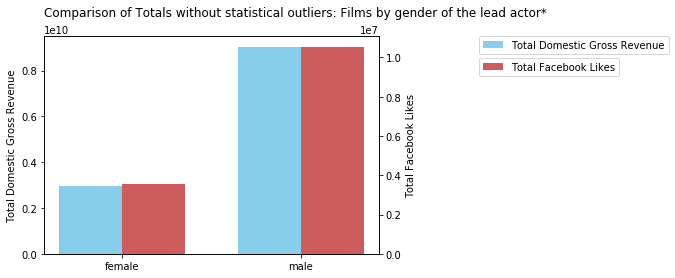

saved to  graphs/bar_r_gross_likes_total_n_o.png


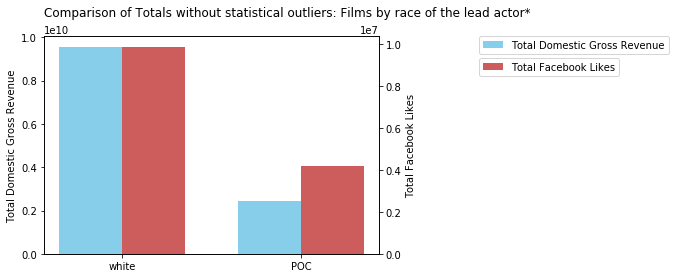

saved to  graphs/bar_gr_gross_likes_total_n_o.png


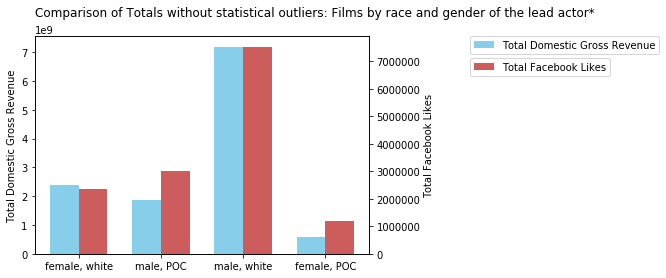

In [113]:
#Totals

a = movie_topcats_likes_sums.query('cat == "male" | cat == "female"')
b = movie_topcats_gross_sums.query('cat == "male" | cat == "female"')
g = b.merge(a,on='cat')

a = movie_topcats_likes_sums.query('cat == "white" | cat == "POC"')
b = movie_topcats_gross_sums.query('cat == "white" | cat == "POC"')
r = a.merge(b,on='cat')

a = movies_subcats_likes_sums
b = movies_subcats_gross_sums
print(a)
print(b)
gr = a.merge(b,on='cat')

vis_bar(title='Comparison of Totals without statistical outliers: Films by gender of the lead actor*', 
        filename='bar_g_gross_likes_total_n_o', 
        x_axis=g['cat'], 
        y_axis1=g['gross'], 
        y_label1='Total Domestic Gross Revenue', 
        y_axis2=g['likes'], 
        y_label2='Total Facebook Likes', 
        horizontal_xlabels=True)

vis_bar(title='Comparison of Totals without statistical outliers: Films by race of the lead actor*', 
        filename='bar_r_gross_likes_total_n_o', 
        x_axis=r['cat'], 
        y_axis1=r['gross'], 
        y_label1='Total Domestic Gross Revenue', 
        y_axis2=r['likes'], 
        y_label2='Total Facebook Likes', 
        horizontal_xlabels=True)

vis_bar(title='Comparison of Totals without statistical outliers: Films by race and gender of the lead actor*', 
        filename='bar_gr_gross_likes_total_n_o', 
        x_axis=gr['cat'], 
        y_axis1=gr['gross'], 
        y_label1='Total Domestic Gross Revenue', 
        y_axis2=gr['likes'], 
        y_label2='Total Facebook Likes', 
        horizontal_xlabels=True)

saved to  graphs/bar_g_gross_likes_average_n_o.png


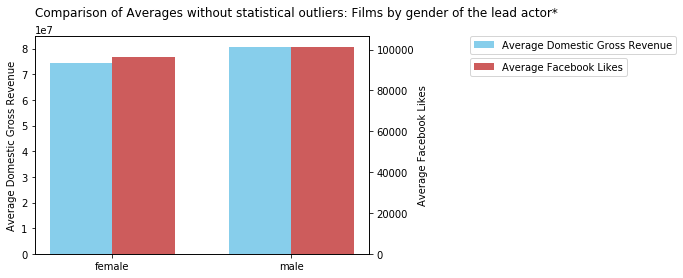

saved to  graphs/bar_r_gross_likes_average_n_o.png


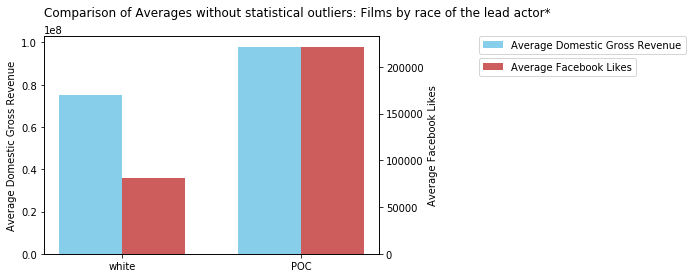

saved to  graphs/bar_gr_gross_likes_average_n_o.png


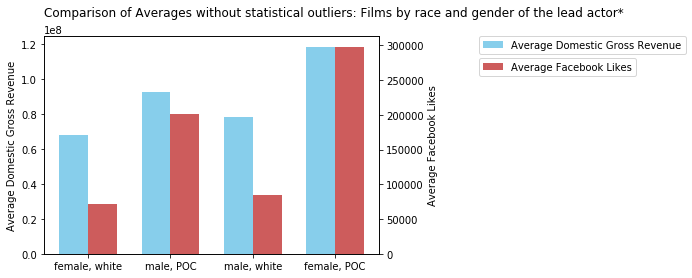

In [114]:
#Averages

a = movie_topcats_likes_means.query('cat == "male" | cat == "female"')
b = movie_topcats_gross_means.query('cat == "male" | cat == "female"')
g = b.merge(a,on='cat')

a = movie_topcats_likes_means.query('cat == "white" | cat == "POC"')
b = movie_topcats_gross_means.query('cat == "white" | cat == "POC"')
r = a.merge(b,on='cat')

a = movies_subcats_likes_means
b = movies_subcats_gross_means
gr = a.merge(b,on='cat')

vis_bar(title='Comparison of Averages without statistical outliers: Films by gender of the lead actor*', 
        filename='bar_g_gross_likes_average_n_o', 
        x_axis=g['cat'], 
        y_axis1=g['gross'], 
        y_label1='Average Domestic Gross Revenue', 
        y_axis2=g['likes'], 
        y_label2='Average Facebook Likes', 
        horizontal_xlabels=True)

vis_bar(title='Comparison of Averages without statistical outliers: Films by race of the lead actor*', 
        filename='bar_r_gross_likes_average_n_o', 
        x_axis=r['cat'], 
        y_axis1=r['gross'], 
        y_label1='Average Domestic Gross Revenue', 
        y_axis2=r['likes'], 
        y_label2='Average Facebook Likes', 
        horizontal_xlabels=True)

vis_bar(title='Comparison of Averages without statistical outliers: Films by race and gender of the lead actor*', 
        filename='bar_gr_gross_likes_average_n_o', 
        x_axis=gr['cat'], 
        y_axis1=gr['gross'], 
        y_label1='Average Domestic Gross Revenue', 
        y_axis2=gr['likes'], 
        y_label2='Average Facebook Likes', 
        horizontal_xlabels=True)

In [ ]:
#Part 7a: Function for making a pie chart
#https://pythonspot.com/matplotlib-pie-chart/
#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
def vis_pie(title, legend, value, label, **keyword_parameters):
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(value, autopct='%1.1f%%',
                                      textprops=dict(color="w"))

    ax.legend(wedges, legend,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title(label)

    if('filename' not in keyword_parameters):
        path='graphs/' + title.replace(" ", "").replace("*", "").replace(":", "") + '.png'
    else:
        path='graphs/' + keyword_parameters['filename'] + '.png'
    
    fig.savefig(path, transparent=True, bbox_inches='tight') #save the graph
    print('saved to ', path)
    
    plt.show()

In [ ]:
#Part 7: Compare total dgr, fb likes, and IMDB Score per categories with pie diagrams
def create_pie_plots():
    vis_pie(title='Comparison of Totals: Film Revenue by gender of the lead actor*', filename='pie_g_gross_total', legend=g['category'], value=g['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by gender of the lead actor*', filename='pie_g_likes_total', legend=g['category'], value=g['total_movie_facebook_likes'], label='Total Facebook Likes')
    
    vis_pie(title='Comparison of Totals: Film Revenue by race of the lead actor*', filename='pie_r_gross_total', legend=r['category'], value=r['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by race of the lead actor*', filename='pie_r_likes_total', legend=r['category'], value=r['total_movie_facebook_likes'], label='Total Facebook Likes')
    
    vis_pie(title='Comparison of Totals: Film Revenue by gender and race of the lead actor*', filename='pie_gr_gross_total', legend=gr['category'], value=gr['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by gender and race of the lead actor*', filename='pie_gr_likes_total', legend=gr['category'], value=gr['total_movie_facebook_likes'], label='Total Facebook Likes')
create_pie_plots()